<a id='home'></a>
### purpose

visualize novelty + within-landscape climates in one PCA

### outline

1. [code](#code)
1. [figures](#figures)

In [1]:
from pythonimports import *
from myfigs import save_pdf

import MVP_summary_functions as mvp

import seaborn as  sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import itertools as it
from matplotlib.lines import Line2D
plt.rcParams.update({'font.family' : 'serif'})

summarydir = '/work/lotterhos/MVP-Offsets/run_20220919/summaries'
figdir = makedir(f'{summarydir}/04_outlier_climate_runs/10_visualize_climate_novelty_PCA/figs')

mvp.latest_commit()
session_info.show()

#########################################################
Today:	November 01, 2023 - 12:30:30 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 419895d157c97717f835390196c13cf973d25eba  
Merge: e20434f 1e09b6c  
Author: Brandon Lind <lind.brandon.m@gmail.com>

Current commit of MVP_offsets:
commit 782ee79eada654ce337935bf61a0984cd76dd9cf  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Oct 4 14:13:12 2023 -0400
#########################################################



<a id='code'></a>
# code
[top](#home)

In [2]:
def get_envdata(ntraits):
    """Retrieve appropriate environmental data given `ntraits`.
    
    Parameters
    ----------
    ntraits : int
        the type of simulations to include (the number of traits under selection)
    """
    if ntraits in ['1-trait', '2-trait']:
        reg_dir = '/home/b.lind/offsets/run_20220919_0-225/gradient_forests/training/training_files'
        env_file = f'{reg_dir}/1231094_envfile_GFready_pooled.txt'
    else:
        tutorial_dir = '/home/b.lind/offsets/run_20220919_tutorial/gradient_forests/training/training_files'
        env_file = f'{tutorial_dir}/tutorial_envfile_GFready_pooled.txt'
    
    envdata = pd.read_table(env_file, index_col=0)
    
    if ntraits == '1-trait':
        envdata = x.temp_opt.to_frame()
    
    return envdata


def standardize_envdata(envdata):
    """Center / standardize each variable in `envdata`.
    
    Parameters
    ----------
    envdata : pd.DataFrame
        columns for environments, rows for populations 
    """
    # fit scaler to within-landscape distribution of env values
    scaler = StandardScaler()
    scaler.fit(envdata)
    
    # center/scale envdata
    std_data = pd.DataFrame(
        scaler.transform(envdata),
        index=envdata.index,
        columns=envdata.columns
    )
    
    return std_data, scaler


def get_novelty_files(ntraits):
    """Retrieve files that give environmental values for Climate Novelty scenarios.
    
    Parameters
    ----------
    ntraits : int
        the type of simulations to include (the number of traits under selection)
    """
    # get novelty climate scenario directories
    if ntraits in ['1-trait', '2-trait']:
        novelty_dir = '/home/b.lind/offsets/climate_outlier_runs/garden_files'
    else:
        assert ntraits == '6-trait'
        novelty_dir = '/home/b.lind/offsets/climate_outlier_runs/tutorial/garden_files'
        
    novelty_files = fs(novelty_dir, startswith='envfile', endswith='.txt')
    assert len(novelty_files) == 12  # 11 novelty + one climate center
    
    return novelty_files


def standardize_novelty_vals(novelty_files, scaler, envdata, std_envdata):
    """Using the distribution of within-landscape envs, `scaler`, transform vals in each novelty_file."""
    novelty_vals = []
    for i, g in enumerate(novelty_files):
#         print(op.basename(g).split("_")[-1].rstrip('.txt'))
        novelty_data = pd.read_table(g, index_col=0)
    
        if len(scaler.get_feature_names_out()) == 1:
            novelty_data = novelty_data.temp_opt.to_frame()

        df = pd.DataFrame(
            scaler.transform(
                novelty_data
            ),
            index=envdata.index,
            columns=envdata.columns
        )

        for col in df.columns:
            assert len(df[col].unique()) == 1

        novelty_vals.append(df.iloc[0][std_envdata.columns.tolist()].to_frame().T)
    
    return pd.concat(novelty_vals)


def get_PCA_loadings(pca_data, n_components=None):
    """Fit PCA to data.
    
    Parameters
    ----------
    pca_data : pd.DataFrame
        centered / standardized environmental data (columns=envs, rows=pops)
    n_components : int
        the number of PCs to estimate
    """
    pca = PCA(n_components=n_components)
    pca.fit(pca_data)

    loadings_pca = pca.transform(pca_data)

    pca_loadings = pd.DataFrame(loadings_pca, index=pca_data.index)
    
    return pca_loadings, pca


def create_PCA_figs(pca_loadings, pca_model, ntraits):
    """From PCA loadings create a scatter plot.
    
    Parameters
    ----------
    pca_loadings : pd.DataFrame
        coordinates of each population (environment) in PC space (columns = PCs, rows = pops)
    pca_model : i forgot to check the type
        output from sklearn.decomposition.PCA.fit - used to get % variance
    ntraits : int
        the type of simulations to include (the number of traits under selection)
    """
    for xcol, ycol in it.combinations(pca_loadings.columns[:3], r=2):
        fig, ax = plt.subplots(figsize=(5, 5))

        for row in pca_loadings.index:  # plot each dot individually
            ax.scatter(
                x=pca_loadings.loc[row, xcol],
                y=pca_loadings.loc[row, ycol],
                c='k' if row < 100 else 'blue',
                marker='o' if row < 100 else '*'
            )
            
        varexp_x, varexp_y = [
            '{:.2f}'.format(pca_model.explained_variance_ratio_[col] * 100)
#             round(pca_model.explained_variance_ratio_[col], 4) * 100
            for col in [xcol, ycol]
        ]

        ax.axes.set_xlabel(f'PCA {xcol + 1} ({varexp_x}%)', fontsize=12)
        ax.axes.set_ylabel(f'PCA {ycol + 1} ({varexp_y}%)', fontsize=12)
        ax.axes.set_title(ntraits)

        # add legend
        handles = [
            Line2D([], [], marker='*', color='blue', markerfacecolor='blue', linewidth=0,
                   markeredgecolor=None, label='Novel Climate', markersize=12),

            Line2D([], [], marker='o', color='k', markerfacecolor='k', linewidth=0,
                   markeredgecolor=None, label='Training Climate', markersize=12),
        ]

        leg = fig.legend(handles=handles, ncol=1, title='Climate Source', fancybox=True, shadow=False,
                         facecolor='whitesmoke', loc='center left', bbox_to_anchor=(1, 0.55), fontsize=12)

        plt.setp(leg.get_title(), family='serif', fontsize=13)

        fig.add_artist(leg)

        plt.tight_layout()
        
        save_pdf(f'{figdir}/{ntraits}_{xcol}_{ycol}_novelty_PCA.pdf')

        plt.show()

    pass


def main(ntraits):
    """Wrapper of other functions to create PCA figures of environmental data.
    
    Parameters
    ----------
    ntraits : int
        the type of simulations to include (the number of traits under selection)
    """
    envdata = get_envdata(ntraits)
    
    std_envdata, scaler = standardize_envdata(envdata)
    
    novelty_files = get_novelty_files(ntraits)
    
    novelty_values = standardize_novelty_vals(novelty_files, scaler, envdata, std_envdata)
    
    # combined standardized values from within-landscape and novelty scenarios
    pca_data = pd.concat([std_envdata, novelty_values]).reset_index(drop=True)
    
    pca_loadings, pca_model = get_PCA_loadings(pca_data)
    
    create_PCA_figs(pca_loadings, pca_model, ntraits)
    
    pass


<a id='figures'></a>
# Figures

[top](#home)

### 2-trait

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/04_outlier_climate_runs/10_visualize_climate_novelty_PCA/figs/2-trait_0_1_novelty_PCA.pdf


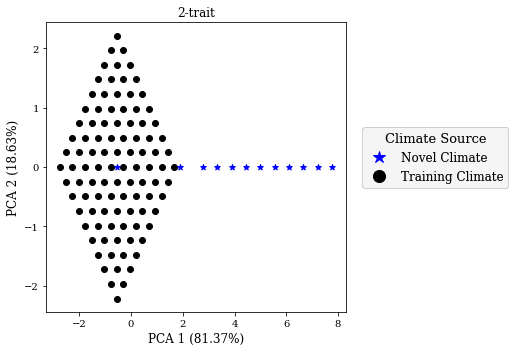

In [3]:
main('2-trait')

### 6-trait

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/04_outlier_climate_runs/10_visualize_climate_novelty_PCA/figs/6-trait_0_1_novelty_PCA.pdf


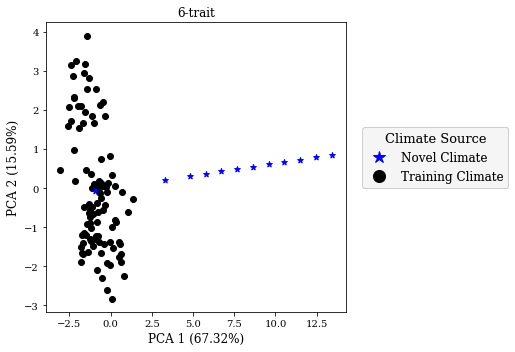

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/04_outlier_climate_runs/10_visualize_climate_novelty_PCA/figs/6-trait_0_2_novelty_PCA.pdf


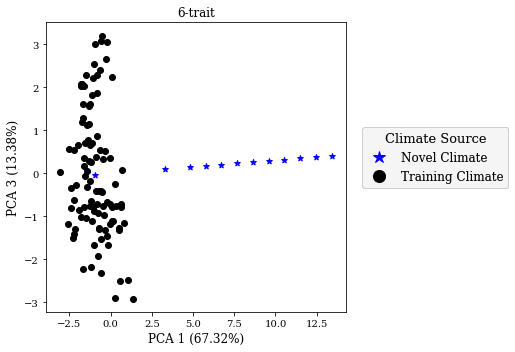

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/04_outlier_climate_runs/10_visualize_climate_novelty_PCA/figs/6-trait_1_2_novelty_PCA.pdf


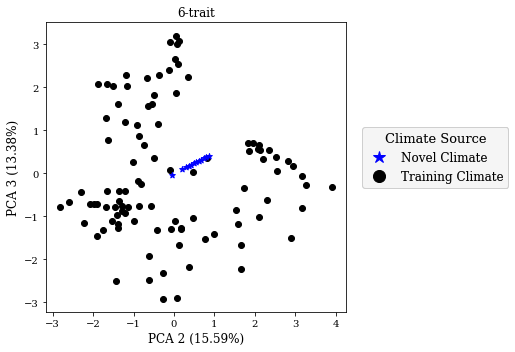

In [4]:
main('6-trait')